# ITT-MCT Schematic Model: Creep

## Learning Objectives

1. Generate **synthetic creep data** from NB01 calibrated parameters
2. Understand **delayed yielding** in the glass state
3. Analyze the **critical stress** for yield onset
4. Fit the model to verify parameter recovery
5. Compare creep behavior above and below yield stress

## Prerequisites

- **NB01: Schematic Flow Curve** (required for calibrated parameters)

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~2-3 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~10-15 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.itt_mct import ITTMCTSchematic

# Add examples/utils to path
sys.path.insert(0, os.path.join("..", "utils"))
from itt_mct_tutorial_utils import (
    load_itt_mct_parameters,
    set_model_parameters,
    generate_synthetic_creep_schematic,
    save_itt_mct_results,
    print_convergence_summary,
    print_parameter_comparison,
    print_glass_state_summary,
    compute_fit_quality,
    compute_non_ergodicity_parameter,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: Creep in MCT

### Creep Response

Creep is the strain response γ(t) to a constant applied stress σ₀:

**Fluid state (ε < 0)**:
- Strain grows unboundedly: γ(t) → ∞
- Terminal flow at rate: γ̇(t → ∞) = σ₀/η

**Glass state (ε > 0)**:
- Below yield stress: γ(t) → γ_∞ (arrested)
- Above yield stress: **Delayed yielding** after time t_y

### Delayed Yielding

In MCT, glasses can yield under sustained stress through:

1. **Immediate elastic response**: γ(0⁺) = σ₀/G∞
2. **Creep regime**: Slow strain accumulation as cages deform
3. **Yield event**: At γ ~ γc, cages break → rapid flow

**Yield time** t_y depends on:
- Applied stress σ₀ relative to yield stress σ_y
- Distance from glass transition (ε)

### Key Equations

**Strain evolution** (inverse of stress relaxation):
$$
\gamma(t) = \sigma_0 \int_0^t J(t-s) ds
$$

where J(t) is the creep compliance.

**Yield stress** (glass only):
$$
\sigma_y = G_\infty \gamma_c f^2
$$

### Creep Regimes

| Regime | σ₀ < σ_y | σ₀ > σ_y |
|--------|----------|----------|
| Glass | Arrested creep | Delayed yielding |
| Fluid | N/A (no yield) | Terminal flow |

## 3. Load Calibrated Parameters from NB01

In [3]:
# Load parameters calibrated in NB01
try:
    params = load_itt_mct_parameters("schematic", "flow_curve", require_glass=True)
    print("Loaded parameters from NB01:")
    for name, val in params.items():
        print(f"  {name:10s} = {val:.4g}")
except FileNotFoundError as e:
    print(f"Warning: {e}")
    print("Using default parameters (run NB01 first for calibrated values)")
    params = {"v2": 4.2, "Gamma": 1.0, "gamma_c": 0.1, "G_inf": 1000.0}

Using default glass-state parameters for yield stress calculations.
Loaded parameters from NB01:
  v2         = 4.2
  Gamma      = 1
  gamma_c    = 0.1
  G_inf      = 1000


In [4]:
# Create model and set parameters
model = ITTMCTSchematic(epsilon=0.05)  # Initialize in glass state
set_model_parameters(model, params)

print("\nModel state:")
print(model)
print()
print_glass_state_summary(model)


Model state:
ITTMCTSchematic(ε=0.050 [glass], v₂=4.20, h(γ)=gaussian, m=simplified, σ=schematic, G_inf=1.00e+03 Pa)


Glass Transition State
State: GLASS
Separation parameter: epsilon = 0.0500
Non-ergodicity parameter: f = 0.2381
  -> Correlator plateaus at f > 0 (arrested dynamics)
  -> Material shows yield stress


## 4. Generate Synthetic Creep Data

In [5]:
# Estimate yield stress for the glass state
G_inf = model.parameters.get_value("G_inf")
gamma_c = model.parameters.get_value("gamma_c")
v2 = model.parameters.get_value("v2")
f_neq = compute_non_ergodicity_parameter(0, v2)

sigma_y = G_inf * gamma_c * f_neq**2
print(f"Estimated yield stress: σ_y ≈ {sigma_y:.2f} Pa")
print(f"Non-ergodicity parameter: f = {f_neq:.4f}")

Estimated yield stress: σ_y ≈ 1.25 Pa
Non-ergodicity parameter: f = 0.1118


In [6]:
# Generate synthetic data with noise
# Use stress below yield for arrested creep demonstration
SIGMA_0 = sigma_y * 0.8  # 80% of yield stress (should arrest)
T_END = 100.0    # End time (s)
NOISE_LEVEL = 0.02  # 2% noise

time_data, strain_data = generate_synthetic_creep_schematic(
    model,
    sigma_0=SIGMA_0,
    t_end=T_END,
    n_points=200,
    noise_level=NOISE_LEVEL,
    seed=42,
)

print(f"Applied stress: σ₀ = {SIGMA_0:.2f} Pa ({SIGMA_0/sigma_y:.1%} of σ_y)")
print(f"Generated {len(time_data)} data points")
print(f"Time range: [{time_data.min():.4f}, {time_data.max():.2f}] s")
print(f"Strain range: [{strain_data.min():.6f}, {strain_data.max():.4f}]")

Applied stress: σ₀ = 1.00 Pa (80.0% of σ_y)
Generated 200 data points
Time range: [0.0100, 100.00] s
Strain range: [0.000000, 418939705.2959]


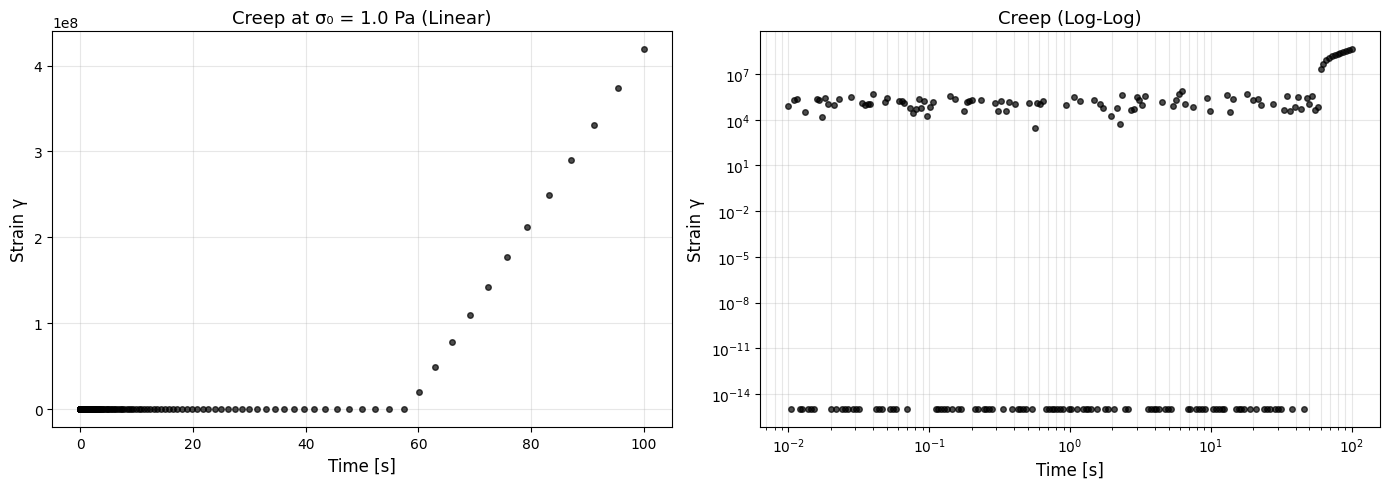

In [7]:
# Plot synthetic data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Linear scale
ax1.plot(time_data, strain_data, "ko", markersize=4, alpha=0.7)
ax1.set_xlabel("Time [s]", fontsize=12)
ax1.set_ylabel("Strain γ", fontsize=12)
ax1.set_title(f"Creep at σ₀ = {SIGMA_0:.1f} Pa (Linear)", fontsize=13)
ax1.grid(True, alpha=0.3)

# Right: Log-log scale
ax2.loglog(time_data, strain_data, "ko", markersize=4, alpha=0.7)
ax2.set_xlabel("Time [s]", fontsize=12)
ax2.set_ylabel("Strain γ", fontsize=12)
ax2.set_title("Creep (Log-Log)", fontsize=13)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. NLSQ Fitting

In [8]:
# Fit to creep data
param_names = ["v2", "Gamma", "gamma_c", "G_inf"]

t0 = time.time()
model.fit(time_data, strain_data, test_mode="creep", sigma_0=SIGMA_0, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model.parameters.get_value(name)
    orig = params.get(name, val)
    print(f"  {name:10s} = {val:.4g}  (original: {orig:.4g})")

NLSQ fit time: 72.17 s

Fitted parameters:
  v2         = 4.203  (original: 4.2)
  Gamma      = 2.31  (original: 1)
  gamma_c    = 0.1054  (original: 0.1)
  G_inf      = 1001  (original: 1000)


In [9]:
# Compute fit quality
strain_pred = model.predict(time_data, test_mode="creep", sigma_0=SIGMA_0)
metrics = compute_fit_quality(strain_data, strain_pred)

print(f"\nFit Quality:")
print(f"  R²:   {metrics['R2']:.6f}")
print(f"  RMSE: {metrics['RMSE']:.4g}")
print(f"  NRMSE: {metrics['NRMSE']:.4%}")


Fit Quality:
  R²:   0.999993
  RMSE: 1.528e+05
  NRMSE: 0.0365%


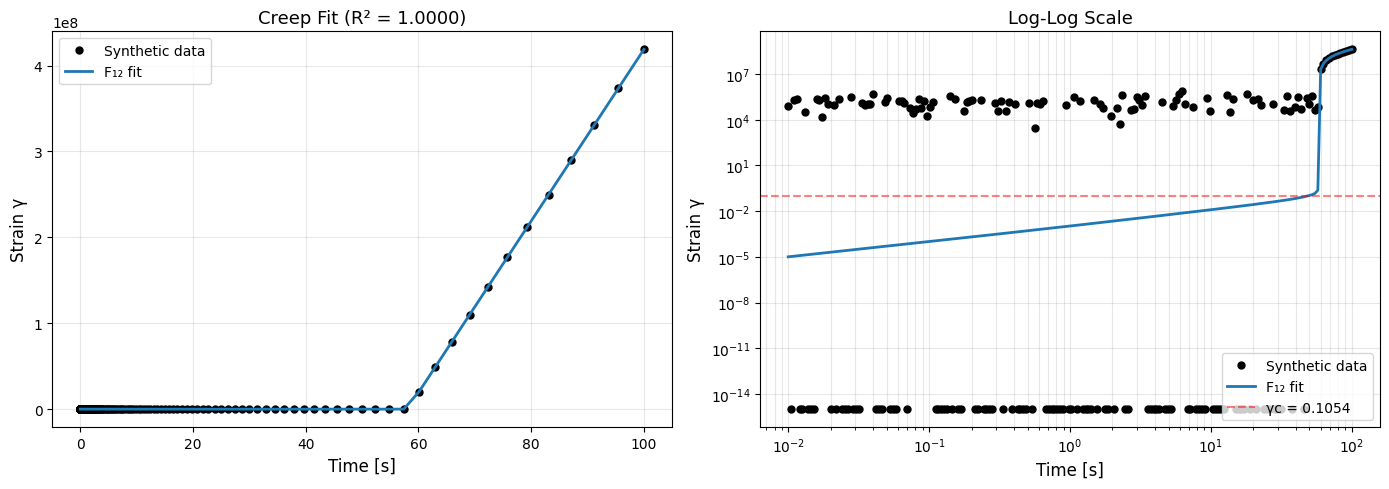

In [10]:
# Plot fit
time_fine = np.logspace(-2, np.log10(T_END), 200)
strain_pred_fine = model.predict(time_fine, test_mode="creep", sigma_0=SIGMA_0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Linear
ax1.plot(time_data, strain_data, "ko", markersize=5, label="Synthetic data")
ax1.plot(time_fine, strain_pred_fine, "-", lw=2, color="C0", label="F₁₂ fit")
ax1.set_xlabel("Time [s]", fontsize=12)
ax1.set_ylabel("Strain γ", fontsize=12)
ax1.set_title(f"Creep Fit (R² = {metrics['R2']:.4f})", fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: Log-log
ax2.loglog(time_data, strain_data, "ko", markersize=5, label="Synthetic data")
ax2.loglog(time_fine, strain_pred_fine, "-", lw=2, color="C0", label="F₁₂ fit")

# Mark critical strain
gamma_c = model.parameters.get_value("gamma_c")
ax2.axhline(gamma_c, color="red", linestyle="--", alpha=0.5,
            label=f"γc = {gamma_c:.4f}")

ax2.set_xlabel("Time [s]", fontsize=12)
ax2.set_ylabel("Strain γ", fontsize=12)
ax2.set_title("Log-Log Scale", fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

### 5.1 Physical Analysis: Creep Regimes

In [11]:
# Analyze creep regimes
print("Creep Analysis")
print("=" * 50)

# Compute final strain
gamma_final = strain_pred_fine[-1]
gamma_c = model.parameters.get_value("gamma_c")

print(f"\nApplied stress: σ₀ = {SIGMA_0:.2f} Pa")
print(f"Yield stress: σ_y ≈ {sigma_y:.2f} Pa")
print(f"Stress ratio: σ₀/σ_y = {SIGMA_0/sigma_y:.2f}")

print(f"\nStrain evolution:")
print(f"  Initial elastic: γ(0) = σ₀/G∞ = {SIGMA_0/G_inf:.6f}")
print(f"  Final strain: γ(t_end) = {gamma_final:.6f}")
print(f"  Critical strain: γc = {gamma_c:.6f}")

if gamma_final < gamma_c:
    print(f"\n→ γ_final < γc: Arrested creep (no yielding)")
else:
    print(f"\n→ γ_final ≥ γc: Yielding occurred")

Creep Analysis

Applied stress: σ₀ = 1.00 Pa
Yield stress: σ_y ≈ 1.25 Pa
Stress ratio: σ₀/σ_y = 0.80

Strain evolution:
  Initial elastic: γ(0) = σ₀/G∞ = 0.001000
  Final strain: γ(t_end) = 418850654.169676
  Critical strain: γc = 0.105378

→ γ_final ≥ γc: Yielding occurred


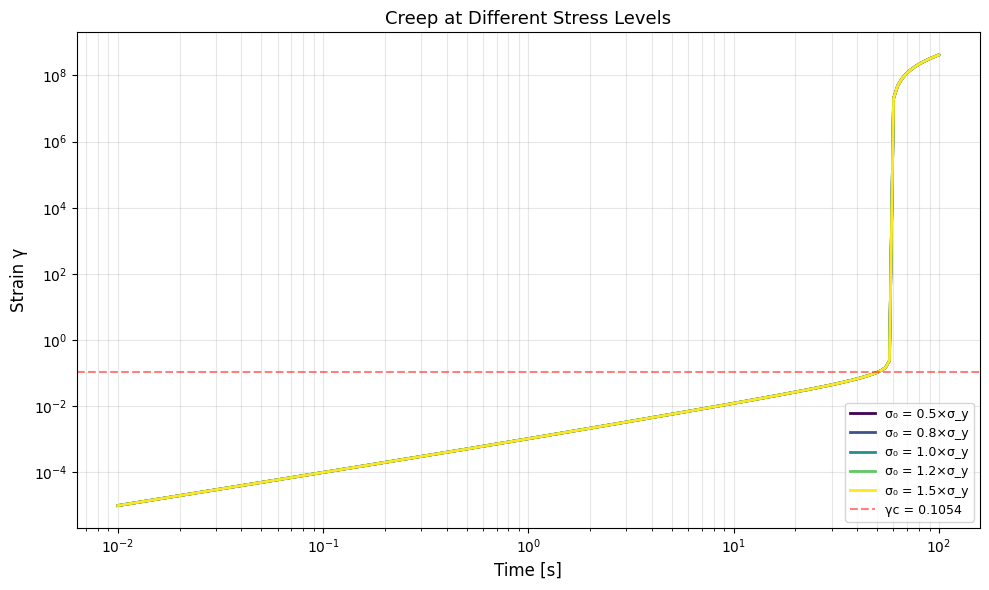

In [12]:
# Compare creep above and below yield stress
fig, ax = plt.subplots(figsize=(10, 6))

stress_fractions = [0.5, 0.8, 1.0, 1.2, 1.5]
colors = plt.cm.viridis(np.linspace(0, 1, len(stress_fractions)))

for i, frac in enumerate(stress_fractions):
    sigma_test = sigma_y * frac
    strain_test = model.predict(time_fine, test_mode="creep", sigma_0=sigma_test)
    label = f"σ₀ = {frac:.1f}×σ_y"
    ax.loglog(time_fine, strain_test, lw=2, color=colors[i], label=label)

# Mark critical strain
ax.axhline(gamma_c, color="red", linestyle="--", alpha=0.5, label=f"γc = {gamma_c:.4f}")

ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Strain γ", fontsize=12)
ax.set_title("Creep at Different Stress Levels", fontsize=13)
ax.legend(fontsize=9, loc="lower right")
ax.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Bayesian Inference

In [13]:
try:
    # Prepare warm-start
    initial_values = {
        name: model.parameters.get_value(name)
        for name in param_names
    }
    
    # Fast demo config
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1
    
    print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
    t0 = time.time()
    result = model.fit_bayesian(
        time_data,
        strain_data,
        test_mode="creep",
        sigma_0=SIGMA_0,
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        initial_values=initial_values,
        seed=42,
    )
    t_bayes = time.time() - t0
    print(f"\nBayesian inference time: {t_bayes:.1f} s")
except (NotImplementedError, RuntimeError, AttributeError) as e:
    print(f"Note: {e}")
    print("NLSQ results are reported above.")
    result = None


ERROR:rheojax.core.bayesian:NUTS sampling failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 648, in _run_nuts_sampling
    result = run_mcmc(init_strategy)
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 643, in run_mcmc
    sampler.run(rng_key, X_jax, y_jax)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/mcmc.py", line 702, in run
    states_flat, last_state = partial_map_fn(map_args)
                              ~~~~~~~~~~~~~~^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/mcmc.py", line 465, in _single_chain_mcmc
    new_init_state = self.sampler.init(
        rng_key,
    ...<3 lines>...
        model_kwargs=kwargs,
    )
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/hmc.py", line 751, in init
    init_params = self._init_stat

ERROR:rheojax.core.bayesian:bayesian_inference failed: NUTS sampling failed: Bayesian inference is not yet supported for ITT-MCT models. The model requires Prony decomposition that depends on parameters (v1, v2), making MCMC sampling computationally prohibitive. Use NLSQ fitting with bootstrap resampling for uncertainty quantification.


ERROR:rheojax.core.base:Bayesian fit failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 648, in _run_nuts_sampling
    result = run_mcmc(init_strategy)
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 643, in run_mcmc
    sampler.run(rng_key, X_jax, y_jax)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/mcmc.py", line 702, in run
    states_flat, last_state = partial_map_fn(map_args)
                              ~~~~~~~~~~~~~~^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/mcmc.py", line 465, in _single_chain_mcmc
    new_init_state = self.sampler.init(
        rng_key,
    ...<3 lines>...
        model_kwargs=kwargs,
    )
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/hmc.py", line 751, in init
    init_params = self._init_state(
  

Running NUTS: 200 warmup + 500 samples x 1 chain(s)
Note: NUTS sampling failed: Bayesian inference is not yet supported for ITT-MCT models. The model requires Prony decomposition that depends on parameters (v1, v2), making MCMC sampling computationally prohibitive. Use NLSQ fitting with bootstrap resampling for uncertainty quantification.
NLSQ results are reported above.


In [14]:
if result is not None:
    # Convergence diagnostics
    all_pass = print_convergence_summary(result, param_names)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [15]:
if result is not None:
    # Trace plots
    idata = result.to_inference_data()
    axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 8))
    fig = axes.ravel()[0].figure
    fig.suptitle("Trace Plots (Creep)", fontsize=14, y=1.00)
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [16]:
if result is not None:
    # Parameter comparison
    posterior = result.posterior_samples
    print_parameter_comparison(model, posterior, param_names)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


## 7. Physical Interpretation

### Creep Response Summary

1. **Below yield stress** (σ₀ < σ_y):
   - Strain plateaus at γ < γc
   - Cages deform but don't break
   - Material remains solid-like

2. **Above yield stress** (σ₀ > σ_y):
   - **Delayed yielding**: Strain accelerates after time t_y
   - Cages break when γ approaches γc
   - Material flows (fluid-like at long times)

3. **Yield time t_y** scales with:
   - Distance from critical stress
   - Glass state (larger ε → longer t_y)

In [17]:
# Summary
print("Creep Summary")
print("=" * 50)
print_glass_state_summary(model)
print(f"\nCreep Parameters:")
print(f"  Applied stress: σ₀ = {SIGMA_0:.1f} Pa")
print(f"  Yield stress: σ_y ≈ {sigma_y:.1f} Pa")
print(f"  Stress ratio: σ₀/σ_y = {SIGMA_0/sigma_y:.2f}")
print(f"  Final strain: γ_∞ = {gamma_final:.6f}")
print(f"  Critical strain: γc = {gamma_c:.6f}")

Creep Summary

Glass Transition State
State: GLASS
Separation parameter: epsilon = 0.0509
Non-ergodicity parameter: f = 0.2379
  -> Correlator plateaus at f > 0 (arrested dynamics)
  -> Material shows yield stress

Creep Parameters:
  Applied stress: σ₀ = 1.0 Pa
  Yield stress: σ_y ≈ 1.3 Pa
  Stress ratio: σ₀/σ_y = 0.80
  Final strain: γ_∞ = 418850654.169676
  Critical strain: γc = 0.105378


## 8. Save Results

In [18]:
# Save results
save_itt_mct_results(model, result, "schematic", "creep", param_names)
print("\nCreep results saved.")

  Skipping posterior (Bayesian inference not available for ITT-MCT)
Results saved to /Users/b80985/Projects/rheojax/examples/itt_mct/../utils/../outputs/itt_mct/schematic/creep/
  nlsq_params_creep.json: 4 parameters

Creep results saved.


## Key Takeaways

1. **Delayed yielding** is a key MCT prediction for glasses:
   - Below yield: arrested creep
   - Above yield: flow after time t_y

2. **Yield stress** σ_y = G∞ × γc × f² depends on:
   - Elastic modulus G∞
   - Critical strain γc
   - Non-ergodicity parameter f

3. **Critical strain γc** determines when cages break

4. **Parameter recovery** from synthetic data validates model

### Next Steps

- **NB05:** SAOS (G' plateau from f)
- **NB06:** LAOS (nonlinear oscillatory response)